In [12]:
# Constants for mass and dimensions 
m_m = 0.1  # Mass of a motor (kg)
m_r = 0.025  # Mass of a rod (kg)
l = 0.35/2  # Length of one arm (meters)

# Calculate moments of inertia
Jx = 2 * l**2 * (m_m + m_r / 3)  # Moment of inertia about the x-axis (kg*m^2)
Jy = Jx  # Moment of inertia about the y-axis (symmetric)
Jz = 2 * Jx  # Moment of inertia about the z-axis

# Print the calculated moments of inertia
print("Moment of inertia about x-axis (Jx):", Jx, "kg*m^2")
print("Moment of inertia about y-axis (Jy):", Jy, "kg*m^2")
print("Moment of inertia about z-axis (Jz):", Jz, "kg*m^2")

Moment of inertia about x-axis (Jx): 0.006635416666666666 kg*m^2
Moment of inertia about y-axis (Jy): 0.006635416666666666 kg*m^2
Moment of inertia about z-axis (Jz): 0.013270833333333332 kg*m^2


In [3]:
from sympy import *
import numpy as np
        
        
params = {
    'm': 1,             # mass (kg)
    'Jx': round(Jx, 6), # moment of inertia about x-axis (kg·m²)
    'Jy': round(Jy, 6), # moment of inertia about y-axis
    'Jz': round(Jz, 6), # moment of inertia about z-axis
    'k': 1.5,           # thrust coefficient (N / rad²/s²)
    'b': 0.5,           # aerodynamic drag coefficient (Nm / rad/s)
    'l': 0.175,         # arm length (m)
    'g': 9.81,          # acceleration due to gravity (m/s²)
}

# Simplify and assign parameter values
m = nsimplify(params['m'])
Jx = nsimplify(params['Jx'])
Jy = nsimplify(params['Jy'])
Jz = nsimplify(params['Jz'])
l = nsimplify(params['l'])
g = nsimplify(params['g'])
k = nsimplify(params['k'])
b = nsimplify(params['b'])
J = diag(Jx, Jy, Jz)

# Define symbols for position, angles, velocity, and angular velocity
p_x, p_y, p_z = symbols('p_x, p_y, p_z')    # position (meters)
psi, theta, phi = symbols('psi, theta, phi') # yaw, pitch, roll angles (radians)
v_x, v_y, v_z = symbols('v_x, v_y, v_z')     # linear velocity (m/s)
w_x, w_y, w_z = symbols('w_x, w_y, w_z')     # angular velocity (rad/s)

# Define net rotor torques and forces
w1, w2, w3, w4 = symbols('w1, w2, w3, w4')   # rotor speeds (rad/s)
tau_x = l * k * (w4**2 - w2**2)              # x-axis torque (Nm)
tau_y = l * k * (w3**2 - w1**2)              # y-axis torque (Nm)
tau_z = b * (w1**2 - w2**2 + w3**2 - w4**2)   # z-axis torque (Nm)
f_z = k * (w1**2 + w2**2 + w3**2 + w4**2)     # net rotor force (N)

# Define rotation matrices
Rz = Matrix([[cos(psi), -sin(psi), 0], [sin(psi), cos(psi), 0], [0, 0, 1]])
Ry = Matrix([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])
Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# Calculate angular velocity to angular rates transformation matrix
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = simplify(Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Calculate applied forces and torques
f_in_body = R_body_in_world.T @ Matrix([[0], [0], [-m * g]]) + Matrix([[0], [0], [f_z]])
tau_in_body = Matrix([[tau_x], [tau_y], [tau_z]])

# Define equations of motion
f = Matrix.vstack(
    R_body_in_world @ Matrix([v_x, v_y, v_z]),
    (1 / m) * (f_in_body - Matrix([w_x, w_y, w_z]).cross(m * Matrix([v_x, v_y, v_z]))),
    M @ Matrix([w_x, w_y, w_z]),
    J.inv() @ (tau_in_body - Matrix([w_x, w_y, w_z]).cross(J @ Matrix([w_x, w_y, w_z]))),
)

# Simplify the equations of motion
f = simplify(f, full=True)

# Display the simplified equations of motion
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[                                                                                         -v_x*w_z + v_z*w_x - 981*sin(phi)*cos(theta)/100],
[                                          v_x*w_y - v_y*w_x + 3*w1**2/2 + 3*w2**2/2 + 3*w3**2/2 + 3*w4**2/2 - 981*cos(phi)*cos(theta)/100],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[   

The equations of motion have this form:

$$\begin{bmatrix} \dot{p_x} \\ \dot{p_y} \\ \dot{p_z} \\ \dot{v_x} \\ \dot{v_y} \\ \dot{v_z} \\ \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{\omega_x} \\ \dot{\omega_y} \\ \dot{\omega_z} \end{bmatrix}=f\left(p_x, p_y, p_z, v_x, v_y, v_z, \phi, \theta, \psi, \omega_x, \omega_y, \omega_z, \omega_1, \omega_2, \omega_3, \omega_4\right)$$

In [3]:
from sympy import lambdify, sqrt

def evaluate_system_at_equilibrium(f, m, k):
    # Define equilibrium conditions
    p_xe, p_ye, p_ze = 0, 0, 0
    psi_e, theta_e, phi_e = 0, 0, 0
    v_xe, v_ye, v_ze = 0, 0, 0
    w_xe, w_ye, w_ze = 0, 0, 0

    # Compute equilibrium rotor speeds
    w1e = sqrt((9.81 * m) / (4 * k))
    w2e = w1e
    w3e = w1e
    w4e = w1e

    # Convert symbolic function to a numerical function
    f_num = lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, w1, w2, w3, w4], f)

    # Evaluate the numerical function at equilibrium conditions
    check = f_num(p_xe, p_ye, p_ze, psi_e, theta_e, phi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, w1e, w2e, w3e, w4e)
    print('check =', check)

# Example usage
m = 1     # Mass (kg)
k = 1.5   # Thrust coefficient (N / rad²/s²)

# Call the function to evaluate the system at equilibrium
evaluate_system_at_equilibrium(f, m, k)

check = [[0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [-1.77635683940025e-15]
 [0.0]
 [0.0]
 [0.0]
 [0]
 [0]
 [0]]


In [4]:
import numpy as np
from sympy import lambdify, sqrt

# Define equilibrium values
pxe = 0.0
pye = 0.0
pze = 0.0
psie = 0.0
thetae = 0.0
phie = 0.0
vxe = 1.0
vye = 1.0
vze = 1.0
wxe = 0.0
wye = 0.0
wze = 0.0

w1e = sqrt((9.81 * m) / (4 * k))
w2e = w1e
w3e = w1e
w4e = w1e

# Define symbolic Jacobians and convert to numerical functions
A_jac = f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
B_jac = f.jacobian([w1, w2, w3, w4])

A_num = lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, w1, w2, w3, w4], A_jac)
B_num = lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, w1, w2, w3, w4], B_jac)

# Evaluate Jacobians at equilibrium points to get matrices A and B
A = A_num(pxe, pye, pze, psie, thetae, phie, vxe, vye, vze, wxe, wye, wze, w1e, w2e, w3e, w4e)
B = B_num(pxe, pye, pze, psie, thetae, phie, vxe, vye, vze, wxe, wye, wze, w1e, w2e, w3e, w4e)

# Convert matrices to numpy arrays with float dtype
A = np.array(A, dtype=float)
B = np.array(B, dtype=float)

# Print matrices A and B
print('A =')
print(A)
print('B =')
print(B)

A =
[[ 0.    0.    0.   -1.    1.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.   -1.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -1.    1.   -0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.   -0.    0.   -1.    1.  ]
 [ 0.    0.    0.    0.    0.   -9.81 -0.    0.    0.    1.    0.   -1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.    0.   -1.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.   -0.    0.    0.    0.    0.    1.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
B =
[[   0.            0.            0.            0.        ]
 [   0.            0.           

In [5]:
from scipy.signal import place_poles

# Define the desired range of pole locations for pole placement
pole = np.linspace(-1, -5, 12)

# Use place_poles to compute the state feedback gain matrix K
K = place_poles(A, B, pole).gain_matrix

# Compute the eigenvalues of the closed-loop system
eigK = np.linalg.eigvals(A - B @ K)

# Check if all eigenvalues have negative real parts to determine stability
if np.all(np.real(eigK) < 0):
    print('The closed-loop system is stable.')

The closed-loop system is stable.


In [6]:
from scipy.integrate import solve_ivp

x0 = np.array([0]*12)
def PG1(t, x):
    x_des = np.array([0,0,1,0,0,0,0,0,0,0,0,0])
    x_error = (x - x_des)
    x_dot = (A - B @ K) @ x_error
    return x_dot

t = (0, 130)
solution = solve_ivp(PG1, t, x0)

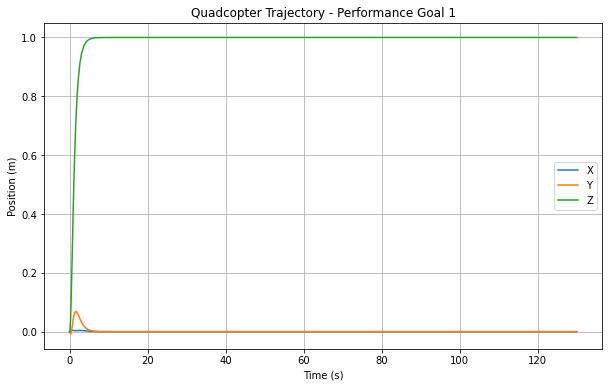

In [7]:
# Extract the solution from solve_ivp
t = solution.t  # Time points
x_traj = solution.y  # State trajectory

# Extract position components from the state trajectory
pos_x = x_traj[0, :]  # Position x component
pos_y = x_traj[1, :]  # Position y component
pos_z = x_traj[2, :]  # Position z component

# Plot the position components over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t, pos_x, label='X')
plt.plot(t, pos_y, label='Y')
plt.plot(t, pos_z, label='Z')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Quadcopter Trajectory - Performance Goal 1')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def PG2(t, x):
    v = .5
    r = 2
    w = v/r
    x_des = np.array([r*np.sin(w*t),r*np.cos(w*t),1,0,0,0,0,0,0,0,0,9.81*m])
    x_error = (x - x_des)   
    x_dot = (A - B @ K) @ x_error
    return x_dot

t = (0, 70)
solution = solve_ivp(PG2, t, x0)

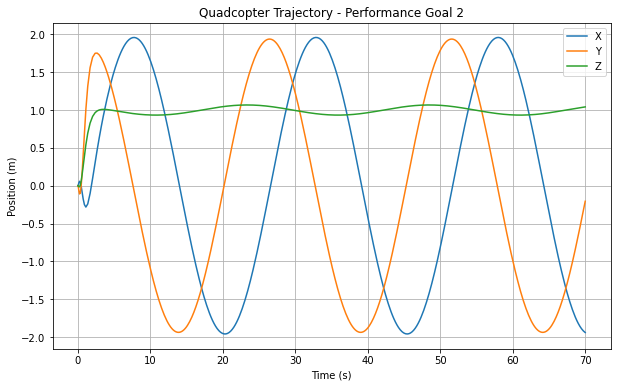

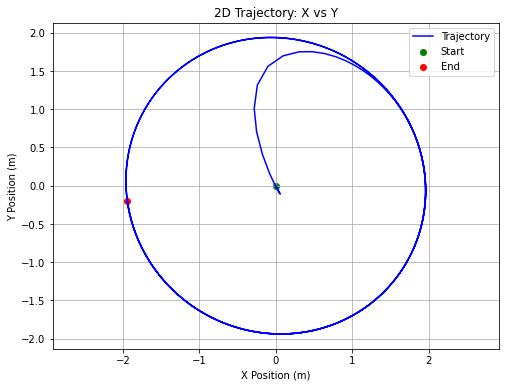

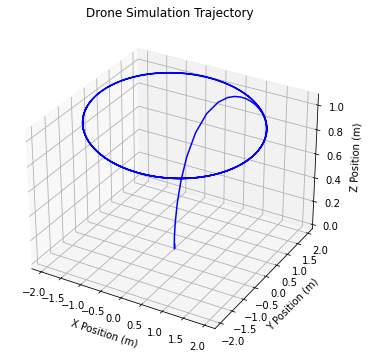

In [9]:
# Extract the solution from solve_ivp
t = solution.t  # Time points
x_traj = solution.y  # State trajectory

# Assuming the state vector x consists of [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, ...]

# Extract position components from the state trajectory
pos_x = x_traj[0, :]  # Position x component
pos_y = x_traj[1, :]  # Position y component
pos_z = x_traj[2, :]  # Position z component

# Plot the position components over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t, pos_x, label='X')
plt.plot(t, pos_y, label='Y')
plt.plot(t, pos_z, label='Z')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Quadcopter Trajectory - Performance Goal 2')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(pos_x, pos_y, label='Trajectory', color='b')
plt.scatter(pos_x[0], pos_y[0], label='Start', color='g', marker='o')  # Mark start point
plt.scatter(pos_x[-1], pos_y[-1], label='End', color='r', marker='o')  # Mark end point
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('2D Trajectory: X vs Y')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling of x and y axes
plt.show()

fig = plt.figure(figsize=(8, 6))  # Adjust figsize as needed
ax = fig.add_subplot(111, projection='3d')
# Plot the 3D trajectory
ax.plot3D(pos_x, pos_y, pos_z, label='Trajectory', color='b')
# Set labels with units and title
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
plt.title('Drone Simulation Trajectory')
# Show the plot
plt.show()

In [10]:
x0 = np.array([0]*12)
def PG3(t, x):
    v = 1
    if t<6:
        x_des = np.array([0,0,1,0,0,0,0,0,0,0,0,0])
    elif x[0]<4.4:
        x_des = np.array([v*(t-6),0,1,0,0,0,0,0,0,0,0,0])
    elif t<16:
        x_des = np.array([5,0,1,0,0,0,0,0,0,0,0,0])
    elif t<20:
        x_des = np.array([5,0,1,0,0,0,0,0,np.pi/2,0,0,0])
    elif x[1]<4.4:
        x_des = np.array([5,v*(t-20),1,0,0,0,0,0,np.pi/2,0,0,0])
    elif t<32:
        x_des = np.array([5,5,1,0,0,0,0,0,np.pi/2,0,0,0])
    else:
        x_des = np.array([5,5,np.exp(-t),0,0,0,0,0,np.pi/2,0,0,0])

    x_error = (x - x_des)
    x_dot = (A - B @ K) @ x_error
    return x_dot

t = (0, 40)
solution = solve_ivp(PG3, t, x0)


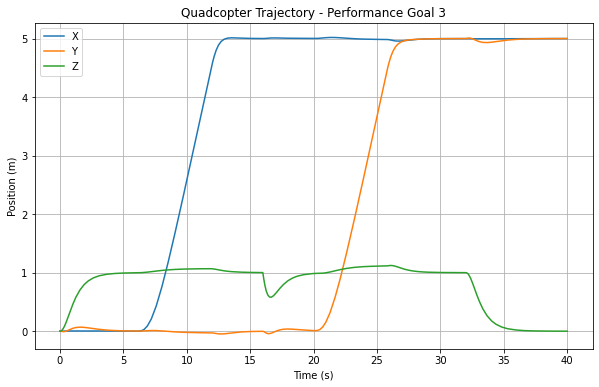

No handles with labels found to put in legend.


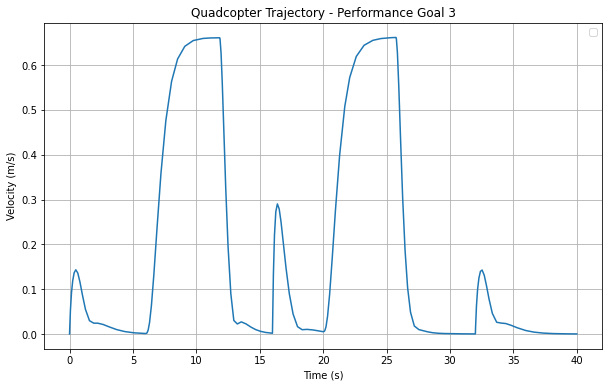

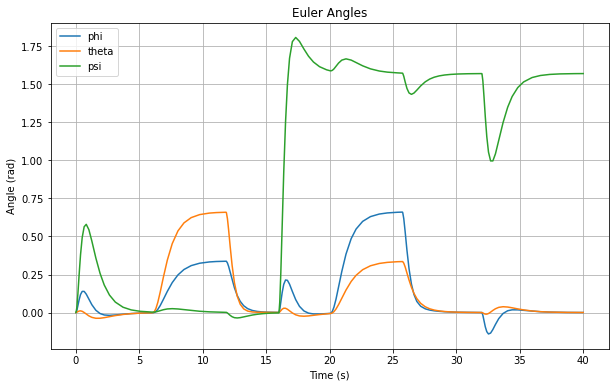

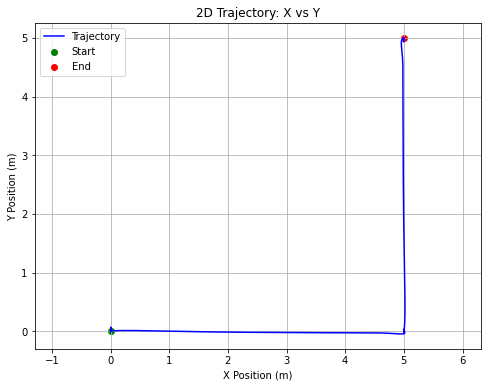

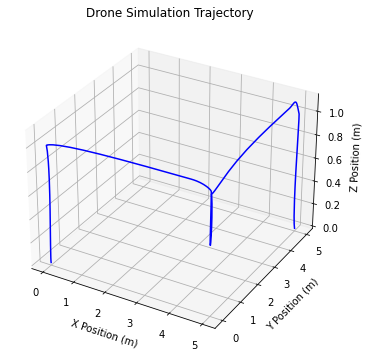

In [11]:
# Extract the solution from solve_ivp
t = solution.t  # Time points
x_traj = solution.y  # State trajectory

# Assuming the state vector x consists of [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, ...]

# Extract position components from the state trajectory
pos_x = x_traj[0, :]  # Position x component
pos_y = x_traj[1, :]  # Position y component
pos_z = x_traj[2, :]  # Position z component

phi = x_traj[6, :]  # phi
theta = x_traj[7, :]  # theta
psi = x_traj[8, :]  # psi

v_x = x_traj[3, :]  # Velocity x component
v_y = x_traj[4, :]  # Velocity y component
v_z = x_traj[5, :]  # Velocity z component
v = np.sqrt(v_x**2 + v_y**2 + v_z**2)

# Plot the position components over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t, pos_x, label='X')
plt.plot(t, pos_y, label='Y')
plt.plot(t, pos_z, label='Z')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Quadcopter Trajectory - Performance Goal 3')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, v)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Quadcopter Trajectory - Performance Goal 3')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, phi, label='phi')
plt.plot(t, theta, label='theta')
plt.plot(t, psi, label='psi')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Euler Angles')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(pos_x, pos_y, label='Trajectory', color='b')
plt.scatter(pos_x[0], pos_y[0], label='Start', color='g', marker='o')  # Mark start point
plt.scatter(pos_x[-1], pos_y[-1], label='End', color='r', marker='o')  # Mark end point
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('2D Trajectory: X vs Y')
plt.legend()
plt.grid(True)
plt.axis('equal')  
plt.show()

fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d')
# Plot the 3D trajectory
ax.plot3D(pos_x, pos_y, pos_z, label='Trajectory', color='b')
# Set labels with units and title
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
plt.title('Drone Simulation Trajectory')
# Show the plot
plt.show()

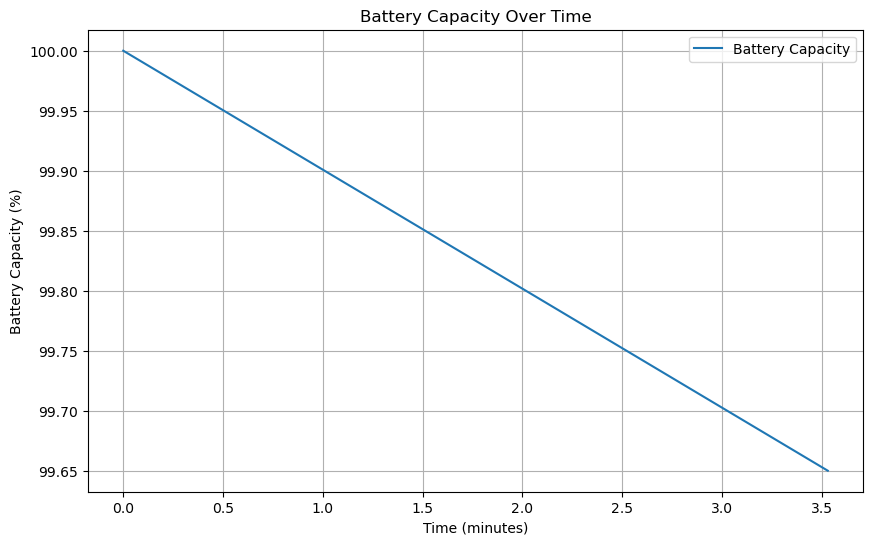

In [17]:
import numpy as np
import matplotlib.pyplot as plt

class Drone:
    def __init__(self, m, l, k, b, IM, Ixx, Iyy, Izz, Ax, Ay, Az):
        self.m = m
        self.l = l
        self.k = k
        self.b = b
        self.IM = IM
        self.Ixx = Ixx
        self.Iyy = Iyy
        self.Izz = Izz
        self.Ax = Ax
        self.Ay = Ay
        self.Az = Az

    def dynamics(self, t, state, omega):
        x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, p, q, r = state

        required_thrust = self.m * 9.81
        omega_hover = np.sqrt(required_thrust / (4 * self.k))
        f1 = f2 = f3 = f4 = self.k * omega_hover**2

        power = [0.5 * self.k * omega_hover**3 for _ in range(4)]
        total_power = sum(power)

        return total_power

voltage = 14.8  # Voltage in volts
capacity_Ah = 1.55  # Capacity in ampere-hours
capacity_Wh = voltage * capacity_Ah  # Total battery capacity in watt-hours

quad = Quadcopter(m=0.3616, l=0.35, k=1.5, b=.5, IM=3.357e-5, Ixx= 0.006635416, Iyy= 0.006635416, Izz=0.013270833, Ax=0.25, Ay=0.25, Az=0.25)
initial_state = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t = np.linspace(0, 1, 2)
power_consumption_W = quad.dynamics(0, initial_state, [0, 0, 0, 0])

time_minutes = np.linspace(0, flight_time_hours * 60, 300)
battery_capacity_percentage = 100 * (1 - (time_minutes / ((capacity_Wh / power_consumption_W) * 60)))

plt.figure(figsize=(10, 6))
plt.plot(time_minutes, battery_capacity_percentage, label='Battery Capacity')
plt.title('Battery Capacity Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Battery Capacity (%)')
plt.grid(True)
plt.legend()
plt.show()
